In [16]:
import torch
import torch.nn as nn
import joblib


#action: try GRU and transformer
# try predicting middle patch, first patch (?) instead of last patch

In [17]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
modes = ['lstm', 'gru', 'transformer']
mode = modes[2]
torch.cuda.empty_cache()
device

'cuda:0'

In [18]:
stride = 32
patch_size = 32
num_patches = 300
# labels = 2
hidden_size = 128

In [19]:
X = torch.load(f'processed_data/X_soft_ps{patch_size}_np{num_patches}.pt')
y = torch.load(f'processed_data/y_soft_ps{patch_size}_np{num_patches}.pt')

# y = y.long()
X = X.float()
y = y.float()

X_ = (X - torch.mean(X)) / torch.std(X)
# if mode == 'transformer':
#     X_ = X_.reshape(X_.shape[0], -1)
# y_ = y[:, y.shape[-1] // 2] 
y_ = y[:, 0]
# scaler = joblib.load('scalers/standard_scaler_4.gz')
# X_ = scaler.transform(X.flatten().unsqueeze(-1)).reshape(X.shape)
# X_ = torch.tensor(X_).float()
# X_.shape
# X_ = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
# X_ = torch.tensor(X_).float()
# X_ = X_[:, :, -1]
X_.shape, y_.shape

/tmp/ipykernel_2691473/3971775135.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load(f'processed_data/X_soft_ps{patch_size}_np{num_patches}.pt')
/tmp/ipykern

(torch.Size([421958, 300, 32]), torch.Size([421958]))

In [20]:
print(y_)

tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [21]:
avg = torch.mean(y_, dim=0)
avg

tensor(0.0965)

In [22]:
train_size = int(0.8 * X_.shape[0])
X_train = X_[:train_size]
y_train = y_[:train_size]
X_val = X_[train_size:]
y_val = y_[train_size:]

print(f'Train size: {X_train.shape}, Test size: {X_val.shape}')

Train size: torch.Size([337566, 300, 32]), Test size: torch.Size([84392, 300, 32])


In [23]:
len(y_val[y_val == 0]), len(y_val[y_val == 1])

(75835, 8358)

In [24]:
from data_loader import BasicDataset

train_dataset = BasicDataset(X_train, y_train)
val_dataset = BasicDataset(X_val, y_val)

In [25]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [26]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([64, 300, 32]) torch.Size([64])


In [27]:
from model import GRU, LSTM, Transformer

if mode == 'lstm':
    model = LSTM(patch_size, hidden_size, 4, 0.1, device).to(device)
elif mode == 'transformer':
    model = Transformer(patch_size, 2, 0.3, device).to(device)
elif mode == 'gru':
    model = GRU(patch_size, hidden_size, 4, 0.3, device).to(device)

# model.load_state_dict(torch.load(f'models/soft_label_model_ps{patch_size}_np{num_patches}_hs{hidden_size}.pt'))



In [32]:
def train_one_epoch(epoch):
    model.train()
    print(f'Epoch: {epoch+1}')
    running_loss = 0.0
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        # print('output', output)
        # print('shape', output.shape)
        # output = output.view(-1, 3)

        # print(output.shape, y_batch.shape)
        # print(output.device, y_batch.device)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        pos = y_batch == 1
        neg = y_batch == 0
        if mode != 'transformer':
            output = torch.sigmoid(output)
    
        tp += (output[pos] >= 0.5).sum().item()
        fp += (output[pos] < 0.5).sum().item()
        tn += (output[neg] < 0.5).sum().item()
        fn += (output[neg] >= 0.5).sum().item()

    
        # correct += len(torch.where(torch.argmax(output, dim=-1) == y_batch.flatten())[0])
        # ttl += len(x_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        if batch_index % 1000 == 999:
            avg_loss_across_batches = running_loss / 1000
            prec = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            # print('Batch {0}, Accuracy: {1:.3f}'.format(batch_index+1, correct/ttl))
            print('Batch {0}, Precision: {1:.3f}, Recall: {2:.3f}'.format(batch_index+1, prec, recall))
            tp = 0
            fp = 0
            tn = 0
            fn = 0 
            running_loss = 0.0
    print()

In [29]:
def validate_one_epoch(epoch):
    model.eval()
    running_loss = 0.0
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            # print(output.shape, y_batch.shape)
            loss = loss_function(output, y_batch)
            if mode != 'transformer':
                output = torch.sigmoid(output)
            pos = y_batch == 1
            neg = y_batch == 0
        
            tp += (output[pos] >= 0.5).sum().item()
            fp += (output[pos] < 0.5).sum().item()
            tn += (output[neg] < 0.5).sum().item()
            fn += (output[neg] >= 0.5).sum().item()
            # normal = torch.where(y_batch.flatten() == 0)
            # anomaly = torch.where(y_batch.flatten() > 0)

            # normal_correct += len(torch.where(torch.argmax(output[normal], dim=-1) == y_batch.flatten()[normal])[0])
            # anomaly_correct += len(torch.where(torch.argmax(output[anomaly], dim=-1) == y_batch.flatten()[anomaly])[0])

            # correct += len(torch.where(torch.argmax(output, dim=-1) == y_batch.flatten())[0])
            # normal_ttl += len(normal[0])
            # anomaly_ttl += len(anomaly[0])
            # ttl += len(x_batch)
            # correct += len(torch.where(torch.argmax(output, dim=-1) == y_batch.flatten())[0])
            # ttl += len(x_batch)
            running_loss += loss.item()
    avg_loss_across_batches = running_loss / len(test_loader)

    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    print('Val Loss: {0:.9f}'.format(avg_loss_across_batches))
    print('Val Precision: {1:.3f}, Recall: {2:.3f}'.format(batch_index+1, prec, recall))
    # print(ttl, y_test.size(0))
    # print('Val Accuracy: {0:.9f}'.format(correct/ttl))
    # print('Val Accuracy (correct normal predict): {0:.9f}'.format(normal_correct/normal_ttl))
    # print('Val Accuracy (correct anomaly predict): {0:.9f}'.format(anomaly_correct/anomaly_ttl))
    print('***************************************************')
    print()

In [33]:
num_epochs = 10
lr = 0.001
# weights = torch.max(y_train.bincount()) / y_train.bincount()
# print(weights, y_train.bincount())
sigmoid = nn.Sigmoid()
weights = torch.tensor([1.0, 10.0])
if model == 'transformer':
    loss_function = nn.MSELoss.to(device)
else:
    loss_function = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([2.0])).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    train_one_epoch(epoch)
    validate_one_epoch(epoch)

Epoch: 1
Batch 1000, Loss: 0.446
Batch 1000, Precision: 0.006, Recall: 0.436
Batch 2000, Loss: 0.451
Batch 2000, Precision: 0.011, Recall: 0.429
Batch 3000, Loss: 0.439
Batch 3000, Precision: 0.006, Recall: 0.351
Batch 4000, Loss: 0.442
Batch 4000, Precision: 0.015, Recall: 0.396
Batch 5000, Loss: 0.436
Batch 5000, Precision: 0.008, Recall: 0.341

Val Loss: 0.499170801
Val Precision: 0.098, Recall: 0.323
***************************************************

Epoch: 2
Batch 1000, Loss: 0.439
Batch 1000, Precision: 0.009, Recall: 0.415
Batch 2000, Loss: 0.445
Batch 2000, Precision: 0.011, Recall: 0.428
Batch 3000, Loss: 0.438
Batch 3000, Precision: 0.008, Recall: 0.403
Batch 4000, Loss: 0.437
Batch 4000, Precision: 0.016, Recall: 0.451
Batch 5000, Loss: 0.443
Batch 5000, Precision: 0.010, Recall: 0.424

Val Loss: 0.501721573
Val Precision: 0.114, Recall: 0.322
***************************************************

Epoch: 3
Batch 1000, Loss: 0.439
Batch 1000, Precision: 0.012, Recall: 0.445
B

In [34]:
print(train_dataset[0][0].shape)
out = model(train_dataset[2100][0].unsqueeze(0).to(device))

out = sigmoid(out)
out, train_dataset[2100][1]

torch.Size([300, 32])


(tensor([0.0106], device='cuda:0', grad_fn=<SigmoidBackward0>), tensor(0.))

In [35]:
fn = -4
st = fn*9173

data = X_[st:st+9173]
true = y_[st:st+9173]
data.shape

torch.Size([9173, 300, 32])

In [36]:
out = []
for i in range(0, len(data), num_patches):
    out.append(model(data[i:i+num_patches].to(device)).detach().cpu())

In [37]:
out = torch.cat(out)
out = sigmoid(out)
out.shape

torch.Size([9173])

In [38]:
# torch.save(model.state_dict(), f'models/soft_label_model_ps{patch_size}_np{num_patches}_hs{hidden_size}.pt')

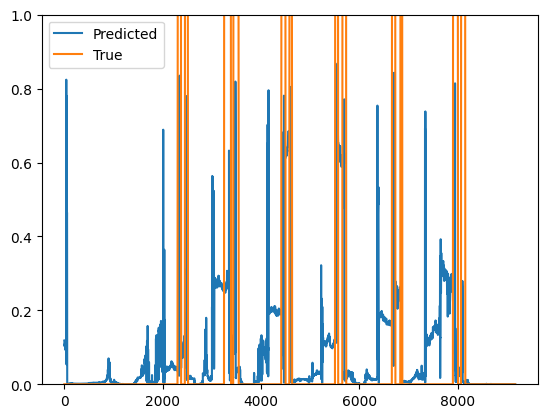

In [39]:
import matplotlib.pyplot as plt
plt.plot(out, label='Predicted')
plt.plot(true, label='True')
plt.ylim(0, 1)
plt.legend()

(-10.0, 10.0)

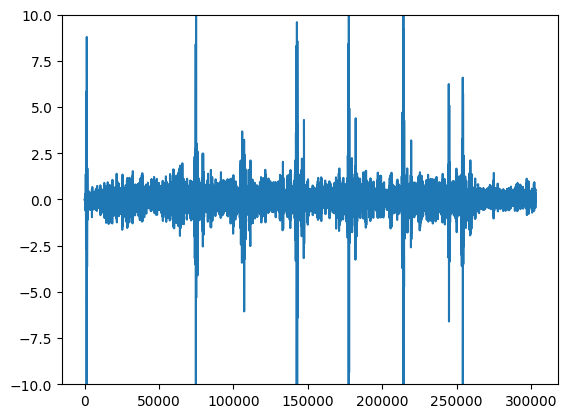

In [40]:
import glob
import numpy as np

data = glob.glob('Data/*.npz')
data.sort()
lf = data[fn]
inp = np.load(lf)['arr_0'][-1]
# inp = scaler.transform(np.moveaxis(inp[1:], 0, -1))

inp = (inp - np.mean(inp)) / np.std(inp)
plt.plot(inp)
plt.ylim(-10, 10)